#Creating INPUT-TARGET PAIRS


Implementing Data Loader that fetches input-target pairs using sliding windows approach

(S1) Tokenization using BPE

In [1]:
!pip3 install tiktoken

In [2]:
import importlib
import tiktoken

In [3]:
tokenizer = tiktoken.get_encoding("gpt2")

In [6]:
with open("the-verdict.txt", "r", encoding = "utf-8") as f:
  rawtext = f.read()
encodedText = tokenizer.encode(rawtext)
print(encodedText[:15])
print(len(encodedText))  # Vocabulary Size

[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016]
5145


In [8]:
encodedSample = encodedText[50:] # Removes first 50 tokens

In [9]:
contextSize = 4 #Len of input
# Context size of 4 means that the model is trained to look at a sequence of 4 words or tokens to predict the next word in the sequence
# input x [1, 2, 3, 4]  and the target 4 [2, 3, 4, 5]

x = encodedSample[:contextSize]
y = encodedSample[1:contextSize+1]
print(x)
print(y)


[290, 4920, 2241, 287]
[4920, 2241, 287, 257]


In [10]:
for i in range(1, contextSize+1):
  context = encodedSample[:i];
  desired = encodedSample[i];

  print(context, "-->", desired)

[290] --> 4920
[290, 4920] --> 2241
[290, 4920, 2241] --> 287
[290, 4920, 2241, 287] --> 257


In [12]:
for i in range(1, contextSize+1):
  context = encodedSample[:i];
  desired = encodedSample[i];

  print(tokenizer.decode(context), "-->", tokenizer.decode([desired]))


 and -->  established
 and established -->  himself
 and established himself -->  in
 and established himself in -->  a


# IMPLEMENTING A DATA LOADER

Efficient Data Loader Using Pythorch's built in Dataset and DataLoader classes

1) https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html

2) https://docs.pytorch.org/docs/stable/data.html

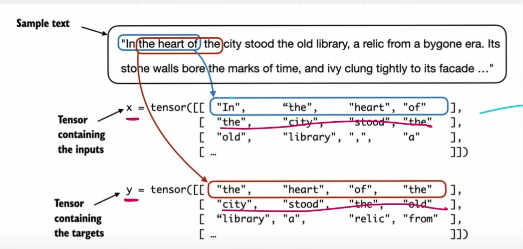

In [18]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, maxLen, stride):
    self.ipIds = []
    self.targetIds = []

    # S1 --> Tokenize the Entire text
    tokenIds = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

    # S2 --> Using sliding window to chunk book into overlapping sequence of maxLen
    for i in range(0, len(tokenIds) - maxLen, stride):
      inputChunk = tokenIds[i:i+maxLen]  # 0->4
      targetChunk = tokenIds[i+1:i+1+maxLen] # 1->5

      self.ipIds.append(torch.tensor(inputChunk))  # Input Tensor X
      self.targetIds.append(torch.tensor(targetChunk)) # Target Tensor Y

  def __len__(self):
    return len(self.ipIds)
  def __getitem__(self, idx):
    return self.ipIds[idx], self.targetIds[idx]  # Ip OP Pairs

In [19]:
def dataLoaderV1(txt, batch_size = 4, max_length = 256,
                 stride = 128, shuffle = True, drop_last = True,
                 num_workers = 0):
  # S1) Initialize the tokenizer
  tokenizer = tiktoken.get_encoding("gpt2")
  # S2) Create Dataset
  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
  # S3) Create Dataloader
  dataloader = DataLoader(dataset, batch_size = batch_size,
                          shuffle = shuffle, drop_last = drop_last,
                          num_workers = num_workers)
  return dataloader


In [21]:
with open("the-verdict.txt", "r", encoding = "utf-8") as a:
  testText = a.read()

In [33]:
import torch
dataloader = dataLoaderV1(testText, batch_size= 1, max_length=4, stride = 1, shuffle = False)
dataIter = iter(dataloader)
firstBatch = next(dataIter)
print(firstBatch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [34]:
secondBatch = next(dataIter)
print(secondBatch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


in above first and second batch stride is 1

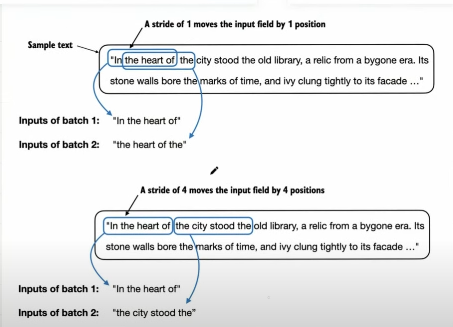

In [35]:
dataloader = dataLoaderV1(testText, batch_size=8, max_length= 4, stride= 4, shuffle = False)
dataIter = iter(dataloader)
inputs, targets = next(dataIter)
print("Inputs:\n", inputs)
print("Targets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


If batch size is small parameters/weights updation will be fast but updates will be noisy , More batch size more time required

And more stride prevents overfitting
